In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
from transformers import AutoTokenizer
from datasets import load_dataset # huggingface datasets
from torchvision import datasets  # torchvision datasets
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import joblib
import seaborn as sns; sns.set(color_codes=True)
import gc
sns.set_style("white")

In [13]:
torch.__version__

'2.0.1'

In [2]:
# Make a cache for optimizers so we can quickly re-compare results without having to re-train
!mkdir -p _cache
cache = joblib.Memory(location='_cache', verbose=0)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# L2O Learned Optimizers

LSTM-based learned optimizers, source code based off of [1]

Optimizer_Grad: Basic 2-cell recurrant network which takes only parameter gradient as input feature  
Optimizer_PP: 2-cell recurrant network with pre-processed input features (normalized magnitudes) [2]

In [51]:
class Optimizer_Grad(nn.Module):
    def __init__(self, hidden_size=20):
        super().__init__()
        self.lstm = nn.LSTMCell(1, hidden_size)
        self.lstm2 = nn.LSTMCell(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size
        
    def forward(self, input, hidden, cell):
        # Preprocess Optionally?
        hidden0, cell0 = self.lstm(input, (hidden[0], cell[0]))
        hidden1, cell1 = self.lstm2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)


In [5]:
# Optimizer with Preprocessed input features
class Optimizer_PP(nn.Module):
    def __init__(self, preproc=False, hidden_size=20, preproc_factor=10.0):
        super().__init__()
        self.hidden_size = hidden_size
        if preproc:
            self.lstm = nn.LSTMCell(2, hidden_size)
        else:
            self.lstm = nn.LSTMCell(1, hidden_size)
        self.lstm2 = nn.LSTMCell(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        self.preproc_threshold = np.exp(-preproc_factor)
        
    def forward(self, inp, hidden, cell):
        if self.preproc:
            # Implement preproc described in Appendix A
            
            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = inp.data
            inp2 = torch.zeros(inp.size()[0], 2).to(device)
            keep_grads = (torch.abs(inp) >= self.preproc_threshold).squeeze()
            inp2[:, 0][keep_grads] = (torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.preproc_factor).squeeze()
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads]).squeeze()
            
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = (float(np.exp(self.preproc_factor)) * inp[~keep_grads]).squeeze()
            inp = Variable(inp2).to(device)
        hidden0, cell0 = self.lstm(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.lstm2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)

In [6]:
# detach_var used for detaching a tensor from the computation graph, from [3]
def detach_var(v):
    var = Variable(v.data, requires_grad=True).to(device)
    var.retain_grad()
    return var

In [7]:
# Main method to fit a learned optimizer. Source code based from [1]

@cache.cache
def fit_optimizer(target_cls, target_to_opt, preproc=False, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    # L2O Optimizer Network
    opt_net = Optimizer_PP(preproc=preproc).to(device)
    # Meta-Optimizer which will optimize the L2O Optimizer Network
    meta_opt = torch.optim.Adam(opt_net.parameters(), lr=lr)
    
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
            # torch.cuda.empty_cache() # CHECK THIS
        
        loss = (np.mean([
            np.sum(do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
            
    return best_loss, best_net

In [8]:
# Runs the learned optimizer on a target function. Source code based from [1] and modified for experiment needs

def do_fit(opt_net, meta_opt, target_class, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True, return_optimizee=False):
    if should_train:
        opt_net.train()
    else:
        opt_net.eval()
        unroll = 1

    target = target_class(training=should_train)
    optimizee = target_to_opt().to(device)
    n_params = 0
    for p in optimizee.parameters():
        n_params += int(np.prod(p.size()))
    hidden_states = [Variable(torch.zeros(n_params, opt_net.hidden_size)).to(device) for _ in range(2)]
    cell_states = [Variable(torch.zeros(n_params, opt_net.hidden_size)).to(device) for _ in range(2)]
    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    all_losses = None
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)
                    
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
        
        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)

        offset = 0
        result_params = {}
        hidden_states2 = [Variable(torch.zeros(n_params, opt_net.hidden_size)).to(device) for _ in range(2)]
        cell_states2 = [Variable(torch.zeros(n_params, opt_net.hidden_size)).to(device) for _ in range(2)]
        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))
            # We do this so the gradients are disconnected from the graph but we still get
            # gradients from the rest
            gradients = detach_var(p.grad.view(cur_sz, 1))

            updates, new_hidden, new_cell = opt_net(
                gradients,
                [h[offset:offset+cur_sz] for h in hidden_states],
                [c[offset:offset+cur_sz] for c in cell_states]
            )
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_sz] = new_hidden[i]
                cell_states2[i][offset:offset+cur_sz] = new_cell[i]

            result_params[name] = p + updates.view(*p.size()) * out_mul
            result_params[name].retain_grad()
            
            offset += cur_sz            

        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()
                
            all_losses = None
                        
            optimizee = target_to_opt(**{k: detach_var(v) for k, v in result_params.items()}).to(device)
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
            
        else:
            optimizee = target_to_opt(**result_params).to(device)
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            cell_states = cell_states2
        
        # gc.collect()
        # torch.cuda.empty_cache()
        
        

    if (return_optimizee):
        return all_losses_ever, optimizee
    # print(all_losses_ever[-1])
    return all_losses_ever

In [52]:
class QuadraticTarget:
    def __init__(self, **kwargs):
        self.W = Variable(torch.randn(10, 10)).to(device)
        self.y = Variable(torch.randn(10)).to(device)
        
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y)**2)
    
class QuadOptimizee(nn.Module):
    def __init__(self, theta=None):
        super().__init__()
        # Note: assuming the same optimization for theta as for
        # the function to find out itself.
        if theta is None:
            self.theta = nn.Parameter(torch.zeros(10))
        else:
            self.theta = theta
        
    def forward(self, target):
        return target.get_loss(self.theta)
    
    def all_named_parameters(self):
        return [('theta', self.theta)]


In [60]:
# for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
# for lr in tqdm([0.003]):
#     print('Trying lr:', lr)
#     print(fit_optimizer(QuadraticTarget, QuadOptimizee, lr=lr)[0])
    
loss, quad_optimizer = fit_optimizer(QuadraticTarget, QuadOptimizee, lr=0.003, n_epochs=100)
print(loss)

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

159.37698
100000000000000000 159.37698


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

173.04018


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

150.92664
159.37698 150.92664


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

139.84154
150.92664 139.84154


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

121.84542
139.84154 121.84542


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

123.317764


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

100.308235
121.84542 100.308235


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

91.40798
100.308235 91.40798


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

108.38376


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

110.01712


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

98.086174


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

95.70103


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

110.1423


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

77.720055
91.40798 77.720055


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

90.117775


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

77.64139
77.720055 77.64139


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

79.266136


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

83.014465


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

78.2516


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

85.69478


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

85.92326


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

79.49045


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

73.752945
77.64139 73.752945


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

80.70408


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

79.571815


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

75.887245


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

77.24469


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

72.18637
73.752945 72.18637


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

78.66137


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

74.792854


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

77.78004


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

83.6038


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

75.02737


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

74.21902


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

65.39268
72.18637 65.39268


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

72.13561


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

68.74446


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

60.290417
65.39268 60.290417


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

72.20968


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

74.21054


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

827.7339


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

88.8831


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

84.780426


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

75.50248


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

65.634125


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

72.31423


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

71.29333


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

76.35071


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

77.68854


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

91.75788


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

73.249535


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

67.36114


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

63.374405


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

52.615795
60.290417 52.615795


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

81.68222


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

61.23402


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

70.61692


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

60.590755


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

65.638115


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

65.81112


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

75.10579


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

71.34833


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

60.349464


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

51.381546
52.615795 51.381546


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

65.07788


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

63.4461


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

62.3214


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

79.264534


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

61.230515


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

62.310947


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

59.340164


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

123.79214


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

100.27095


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

65.746864


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

68.04912


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

70.31191


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

70.988884


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

72.26793


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

46.91977
51.381546 46.91977


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

79.56198


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

68.32873


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

64.53427


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

66.975464


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

61.71798


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

73.4495


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

70.955696


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

93.4698


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

71.73722


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

81.943634


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

70.253395


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

69.17682


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

84.205605


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

78.84609


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

74.74468


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

75.21542


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

62.448887


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

69.55536


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

68.56552


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

63.56735


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

69.34484
46.91977


In [16]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = target_to_opt().to(device)
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            
            total_loss.append(loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError:
            pass
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss, best_lr

In [67]:
NORMAL_OPTS = [(torch.optim.Adam, {}), (torch.optim.RMSprop, {}), (torch.optim.SGD, {}), (torch.optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(QuadraticTarget, QuadOptimizee, opt, lr=lr, **extra_kwargs))

opt = Optimizer_Grad().to(device)
opt.load_state_dict(quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, QuadraticTarget, QuadOptimizee, 1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])


tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

Here, we match the results seen in the papers, where using LSTM optimizer is able to convege faster, and acheive a lower end loss after 100 steps on a simple quadratic target

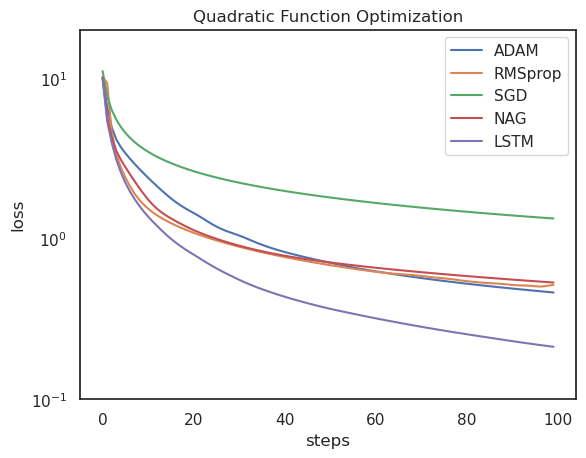

In [83]:
fit_data_est = np.mean(fit_data, axis=0)
plt.plot(fit_data_est[:, :], label=OPT_NAMES + ['LSTM'])

plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.ylim(1e-1, 2e1)
plt.title('Quadratic Function Optimization')
plt.legend()
plt.show()

# MLP on MNIST

In [20]:
class MNISTTarget:
    def __init__(self, training=True):
        dataset = datasets.MNIST('mnist_data', train=training, download=True,
                                 transform=torchvision.transforms.ToTensor()) 
        
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2] # Use only half of the data
        else:
            indices = indices[len(indices) // 2:]
        
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))
    
        self.batches = []
        self.cur_batch = 0

    def get_next_batch(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for batch_idx, (data, target) in enumerate(self.loader):
                self.batches.append((data.to(device), target.to(device)))
        result = self.batches[self.cur_batch]
        self.cur_batch += 1
        return result

class MNISTNet(nn.Module):
    def __init__(self, layer_sizes=[20], **kwargs):
        super().__init__()
        self.layer_sizes = [20]
        if (kwargs != {}):
            self.params = kwargs
        else:
            self.params = {}
            input_size = 28 * 28
            for i, layer_size in enumerate(layer_sizes):
                self.params['W' + str(i)] = nn.Parameter(torch.randn(input_size, layer_size) / np.sqrt(input_size))
                self.params['b' + str(i)] = nn.Parameter(torch.zeros(layer_size))
                input_size = layer_size

            self.params['W' + str(len(layer_sizes))] = nn.Parameter(torch.randn(input_size, 10) / np.sqrt(input_size))
            self.params['b' + str(len(layer_sizes))] = nn.Parameter(torch.zeros(10))

            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
            
        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]

    def forward(self, target: MNISTTarget):
        x, y = target.get_next_batch()
        x = Variable(x.view(x.size()[0], 28*28)).to(device)
        y = Variable(y).to(device)
        # Ensure that the tensors both require_grad
        # Tensors are already moved to device in loader
        # x.requires_grad_()

        for i in range(len(self.layer_sizes)):
            x = self.activation(x @ self.params['W' + str(i)] + self.params['b' + str(i)])
        
        x = F.log_softmax(x @ self.params['W' + str(len(self.layer_sizes))] + self.params['b' + str(len(self.layer_sizes))], dim=1)

        loss = self.loss(x, y)
        return loss
        

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 20

NORMAL_OPTS = [(torch.optim.Adam, {})]
QUAD_LRS = [0.03]

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTTarget, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))


In [21]:
loss, mnist_optimizer = fit_optimizer(MNISTTarget, MNISTNet, lr=0.01, n_epochs=20, n_tests=20, preproc=True, out_mul=0.1)
print(loss)

epochs:   0%|          | 0/20 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [86]:
NORMAL_OPTS = [(torch.optim.Adam, {}), (torch.optim.RMSprop, {}), (torch.optim.SGD, {}), (torch.optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTTarget, MNISTNet, opt, lr=lr, **extra_kwargs))

opt = Optimizer_PP(preproc=True).to(device)
opt.load_state_dict(mnist_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, MNISTTarget, MNISTNet, 1, 100, 100, out_mul=0.1, should_train=False) for _ in range(100)])


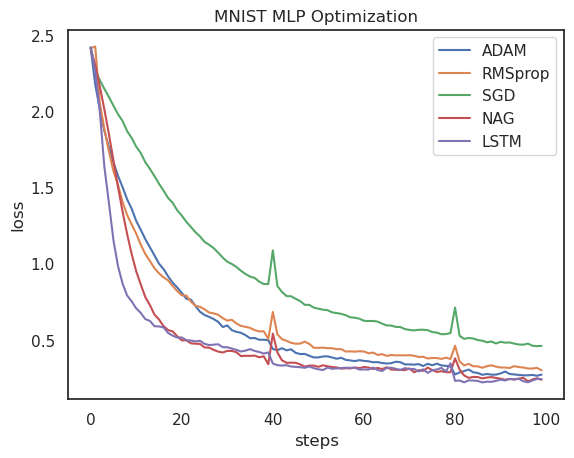

In [88]:
fit_data_mean = np.mean(fit_data, axis=0)
plt.plot(fit_data_mean[:, :], label=OPT_NAMES + ['LSTM'])
plt.legend()
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("MNIST MLP Optimization")
plt.show()

# ConvNet on MNIST

In [22]:
class MNISTTarget:
    def __init__(self, training=True):
        dataset = datasets.MNIST('mnist_data', train=training, download=True,
                                 transform=torchvision.transforms.ToTensor()) 
        
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2] # Use only half of the data
        else:
            indices = indices[len(indices) // 2:]
        
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))
    
        self.batches = []
        self.cur_batch = 0

    def get_next_batch(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for batch_idx, (data, target) in enumerate(self.loader):
                self.batches.append((data.to(device), target.to(device)))
        result = self.batches[self.cur_batch]
        self.cur_batch += 1
        return result

class MNISTResNet(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        if (kwargs != {}):
            self.params = kwargs
        else:
            self.params = {}
            input_size = 28 * 28

            # input image size: 28x28
            # after first conv, 3x3, padding 1 : 28x28
            # after second conv, 3x3, padding 1: 28x28
            # after maxpool: 14x14
            # after batch norm: 14x14
            # after fully connected: 10
            
            # Create the parameters for the first 3x3 convolution layer, padding 1
            self.params['W1'] = nn.Parameter(torch.randn(3, 1, 3, 3) / np.sqrt(3 * 1 * 3 * 3))
            self.params['b1'] = nn.Parameter(torch.zeros(3))

            # Create the parameters for the second 3x3 convolution layer, padding 1
            self.params['W2'] = nn.Parameter(torch.randn(3, 3, 3, 3) / np.sqrt(3 * 3 * 3 * 3))
            self.params['b2'] = nn.Parameter(torch.zeros(3))

            # Create the parameters for the final fully connected output layer, after a 2x2 max pooling
            self.params['W3'] = nn.Parameter(torch.randn(10, 3 * 14 * 14) / np.sqrt(10 * 3 * 14 * 14))
            self.params['b3'] = nn.Parameter(torch.zeros(10))

            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
            
        self.activation = nn.ReLU()
        self.norm = nn.BatchNorm2d(3)
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]

    def forward(self, target: MNISTTarget):
        x, y = target.get_next_batch()
        x = Variable(x.view(x.size()[0], 28*28)).to(device)
        y = Variable(y).to(device)

        residual = x

        # Apply the first convolution, 3x3 with padding 1 and 3 channels
        x = F.conv2d(x.view(x.size()[0], 1, 28, 28), self.params['W1'], bias=self.params['b1'], padding=1)
        x = self.activation(x)

        # shape: Bx3x28x28

        # Apply the second convolution, 3x3 with padding 1
        x = F.conv2d(x, self.params['W2'], bias=self.params['b2'], padding=1)
        # shape: Bx3x28x28

        # Apply residual connection, x shape is Bx3x28x28, residual shape is Bx784
        # Apply residual per filter channel, need to duplicate residual 3 times
        residual = residual.view(residual.size()[0], 1, 28, 28)
        residual = residual.repeat(1, 3, 1, 1)
        x = x + residual
        

        # Apply activation
        x = self.activation(x)

        # Apply max pooling
        x = F.max_pool2d(x, 2)
        
        # Apply batch normalization
        x = self.norm(x)

        # Apply the final fully connected layer
        x = x.view(x.size()[0], -1)
        x = F.linear(x, self.params['W3'], bias=self.params['b3'])
        x = F.log_softmax(x, dim=1)

        loss = self.loss(x, y)
        return loss
        

In [33]:
loss, mnist_res_optimizer = fit_optimizer(MNISTTarget, MNISTResNet, lr=0.01, n_epochs=15, n_tests=5, preproc=True, out_mul=0.1)
print(loss)

epochs:   0%|          | 0/15 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

46.32415
100000000000000000 46.32415


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

51.67104


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

52.606323


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

47.983997


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

46.31411
46.32415 46.31411


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

45.292397
46.31411 45.292397


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

41.825176
45.292397 41.825176


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

43.510464


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

41.03585
41.825176 41.03585


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

41.123985


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

40.24309
41.03585 40.24309


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

40.86561


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

39.577347
40.24309 39.577347


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

41.2624


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/5 [00:00<?, ?it/s]

37.2933
39.577347 37.2933
37.2933


In [94]:
NORMAL_OPTS = [(torch.optim.Adam, {}), (torch.optim.SGD, {'nesterov': True, 'momentum': 0.9})]
for i, (opt, extra_kwargs) in enumerate(NORMAL_OPTS):
    np.random.seed(0)
    print("optimizer: ", opt)
    print(find_best_lr_normal(MNISTTarget, MNISTResNet, opt, n_tests=20, **extra_kwargs))

optimizer:  <class 'torch.optim.adam.Adam'>


Learning rates:   0%|          | 0/7 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

(41.06417, 0.01)
optimizer:  <class 'torch.optim.sgd.SGD'>


Learning rates:   0%|          | 0/7 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

(40.160545, 0.03)


In [95]:
NORMAL_OPTS = [(torch.optim.Adam, {}), (torch.optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', "NAG"]
QUAD_LRS = [0.01, 0.03]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTTarget, MNISTResNet, opt, lr=lr, **extra_kwargs))

# Test learned optimizer on convnet
opt = Optimizer_PP(preproc=True).to(device)
opt.load_state_dict(mnist_res_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, MNISTTarget, MNISTResNet, 1, 100, 100, out_mul=0.1, should_train=False) for _ in range(100)])

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

In [96]:
# Test (mlp) learned optimizer [transfer mlp -> convnet]
opt_mlp = Optimizer_PP(preproc=True).to(device)
opt_mlp.load_state_dict(mnist_optimizer)
fit_data[:, :, len(OPT_NAMES) + 1] = np.array([do_fit(opt_mlp, None, MNISTTarget, MNISTNet, 1, 100, 100, out_mul=0.1, should_train=False) for _ in range(100)])


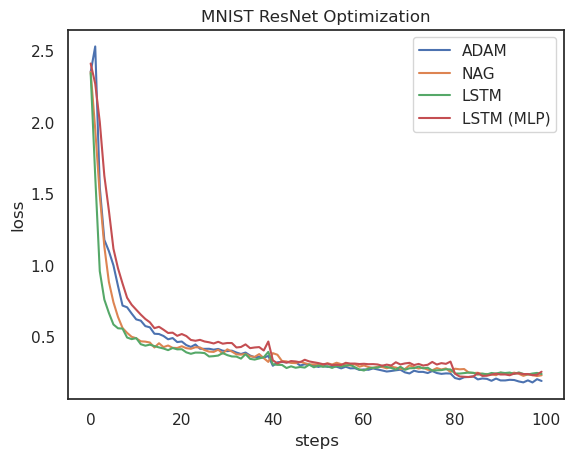

In [98]:
fit_data_mean = np.mean(fit_data, axis=0)
plt.plot(fit_data_mean[:, :], label=OPT_NAMES + ['LSTM', 'LSTM (MLP)'])
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("MNIST ResNet Optimization")
plt.legend()
plt.show()

In [101]:
NORMAL_OPTS = [(torch.optim.Adam, {})]
OPT_NAMES = ['ADAM']
QUAD_LRS = [0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTTarget, MNISTResNet, opt, lr=lr, **extra_kwargs))

# Test (convnet) learned optimizer on mlp [transfer convnet -> mlp]
opt_mlp = Optimizer_PP(preproc=True).to(device)
opt_mlp.load_state_dict(mnist_optimizer)
opt_conv = Optimizer_PP(preproc=True).to(device)
opt_conv.load_state_dict(mnist_res_optimizer)

fit_data[:, :, len(OPT_NAMES) ] = np.array([do_fit(opt_mlp, None, MNISTTarget, MNISTNet, 1, 100, 100, out_mul=0.1, should_train=False) for _ in range(100)])
fit_data[:, :, len(OPT_NAMES) + 1] = np.array([do_fit(opt_conv, None, MNISTTarget, MNISTNet, 1, 100, 100, out_mul=0.1, should_train=False) for _ in range(100)])


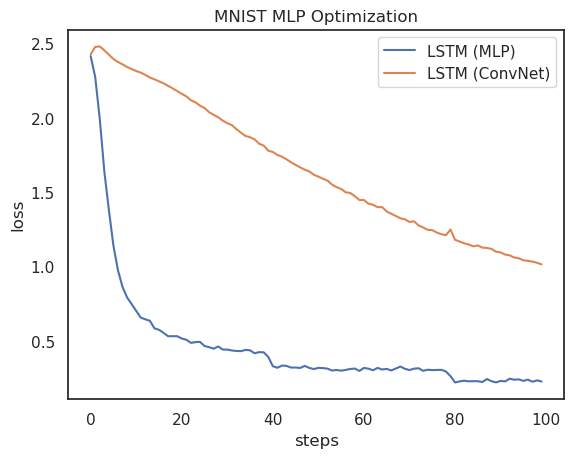

In [113]:
fit_data_mean = np.mean(fit_data, axis=0)
plt.plot(fit_data_mean[:, 1:3], label=['LSTM (MLP)', 'LSTM (ConvNet)'])
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("MNIST MLP Optimization")
plt.legend()
plt.show()

# Transfering Model Architectures

In [28]:

class MNISTResNetSig(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        if (kwargs != {}):
            self.params = kwargs
        else:
            self.params = {}
            input_size = 28 * 28
            
            self.params['W1'] = nn.Parameter(torch.randn(3, 1, 3, 3) / np.sqrt(3 * 1 * 3 * 3))
            self.params['b1'] = nn.Parameter(torch.zeros(3))

            self.params['W2'] = nn.Parameter(torch.randn(3, 3, 3, 3) / np.sqrt(3 * 3 * 3 * 3))
            self.params['b2'] = nn.Parameter(torch.zeros(3))

            self.params['W3'] = nn.Parameter(torch.randn(10, 3 * 14 * 14) / np.sqrt(10 * 3 * 14 * 14))
            self.params['b3'] = nn.Parameter(torch.zeros(10))

            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
            
        self.activation = nn.Sigmoid()
        self.norm = nn.BatchNorm2d(3)
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]

    def forward(self, target: MNISTTarget):
        x, y = target.get_next_batch()
        x = Variable(x.view(x.size()[0], 28*28)).to(device)
        y = Variable(y).to(device)

        residual = x

        x = F.conv2d(x.view(x.size()[0], 1, 28, 28), self.params['W1'], bias=self.params['b1'], padding=1)
        x = self.activation(x)

        x = F.conv2d(x, self.params['W2'], bias=self.params['b2'], padding=1)

        residual = residual.view(residual.size()[0], 1, 28, 28)
        residual = residual.repeat(1, 3, 1, 1)
        x = x + residual
        
        x = self.activation(x)

        x = F.max_pool2d(x, 2)
        
        x = self.norm(x)

        x = x.view(x.size()[0], -1)
        x = F.linear(x, self.params['W3'], bias=self.params['b3'])
        x = F.log_softmax(x, dim=1)

        loss = self.loss(x, y)
        return loss

In [29]:

class MNISTResNetConvSize(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        if (kwargs != {}):
            self.params = kwargs
        else:
            self.params = {}
            input_size = 28 * 28
            
            self.params['W1'] = nn.Parameter(torch.randn(3, 1, 5, 5) / np.sqrt(3 * 1 * 3 * 3))
            self.params['b1'] = nn.Parameter(torch.zeros(3))

            self.params['W2'] = nn.Parameter(torch.randn(3, 3, 5, 5) / np.sqrt(3 * 3 * 3 * 3))
            self.params['b2'] = nn.Parameter(torch.zeros(3))

            self.params['W3'] = nn.Parameter(torch.randn(10, 3 * 14 * 14) / np.sqrt(10 * 3 * 14 * 14))
            self.params['b3'] = nn.Parameter(torch.zeros(10))

            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
            
        self.activation = nn.Sigmoid()
        self.norm = nn.BatchNorm2d(3)
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]

    def forward(self, target: MNISTTarget):
        x, y = target.get_next_batch()
        x = Variable(x.view(x.size()[0], 28*28)).to(device)
        y = Variable(y).to(device)

        residual = x

        x = F.conv2d(x.view(x.size()[0], 1, 28, 28), self.params['W1'], bias=self.params['b1'], padding=2)
        x = self.activation(x)

        x = F.conv2d(x, self.params['W2'], bias=self.params['b2'], padding=2)

        residual = residual.view(residual.size()[0], 1, 28, 28)
        residual = residual.repeat(1, 3, 1, 1)
        x = x + residual
        
        x = self.activation(x)

        x = F.max_pool2d(x, 2)
        
        x = self.norm(x)

        x = x.view(x.size()[0], -1)
        x = F.linear(x, self.params['W3'], bias=self.params['b3'])
        x = F.log_softmax(x, dim=1)

        loss = self.loss(x, y)
        return loss

In [37]:
NORMAL_OPTS = [(torch.optim.Adam, {})]
OPT_NAMES = ['ADAM']
QUAD_LRS = [0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTTarget, MNISTResNetConvSize, opt, lr=lr, **extra_kwargs))

# Test original convnet learned optimizer on these variations
opt_conv = Optimizer_PP(preproc=True).to(device)
opt_conv.load_state_dict(mnist_res_optimizer)

fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt_conv, None, MNISTTarget, MNISTResNetConvSize, 1, 100, 100, out_mul=0.05, should_train=False) for _ in range(100)])

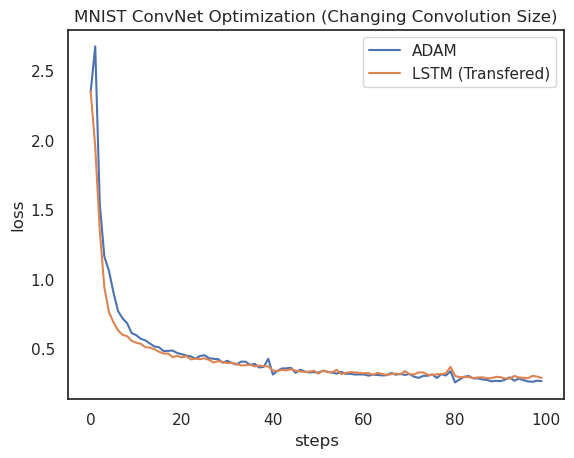

In [38]:

fit_data_mean = np.mean(fit_data, axis=0)
plt.plot(fit_data_mean[:, :], label=['ADAM', 'LSTM (Transfered)'])
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("MNIST ConvNet Optimization (Changing Convolution Size)")
plt.legend()
plt.show()

In [40]:
NORMAL_OPTS = [(torch.optim.Adam, {})]
OPT_NAMES = ['ADAM']
QUAD_LRS = [0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTTarget, MNISTResNetSig, opt, lr=lr, **extra_kwargs))

# Test original convnet learned optimizer on these variations
opt_conv = Optimizer_PP(preproc=True).to(device)
opt_conv.load_state_dict(mnist_res_optimizer)

fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt_conv, None, MNISTTarget, MNISTResNetSig, 1, 100, 100, out_mul=0.05, should_train=False) for _ in range(100)])

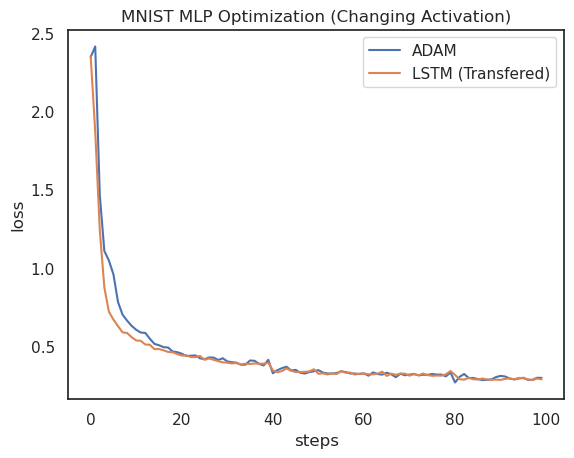

In [41]:
fit_data_mean = np.mean(fit_data, axis=0)
plt.plot(fit_data_mean[:, :], label=['ADAM', 'LSTM (Transfered)'])
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("MNIST MLP Optimization (Changing Activation)")
plt.legend()
plt.show()

# Transfering ConvNet on MNIST to FashionMNIST

In [13]:
class FashionMNISTTarget:
    def __init__(self, training=True):
        dataset = datasets.FashionMNIST('fashion_mnist_data', train=training, download=True,
                                 transform=torchvision.transforms.ToTensor()) 
        
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2] # Use only half of the data
        else:
            indices = indices[len(indices) // 2:]
        
        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))
    
        self.batches = []
        self.cur_batch = 0

    def get_next_batch(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for batch_idx, (data, target) in enumerate(self.loader):
                self.batches.append((data.to(device), target.to(device)))
        result = self.batches[self.cur_batch]
        self.cur_batch += 1
        return result

In [18]:
NORMAL_OPTS = [(torch.optim.Adam, {})]
OPT_NAMES = ['ADAM']
QUAD_LRS = [0.02]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(FashionMNISTTarget, MNISTResNet, opt, lr=lr, **extra_kwargs))
    print(fit_data[:, -1, i].mean(), fit_data[:, -1, i].std())

opt = Optimizer_PP(preproc=True).to(device)
opt.load_state_dict(mnist_res_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, FashionMNISTTarget, MNISTResNet, 1, 100, 100, out_mul=0.1, should_train=False) for _ in range(100)])


0.48871374666690826 0.09540864776101336


NameError: name 'mnist_res_optimizer' is not defined

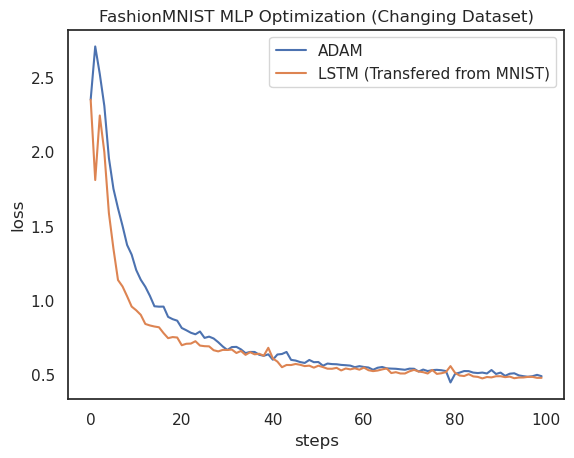

In [135]:
fit_data_mean = np.mean(fit_data, axis=0)
plt.plot(fit_data_mean[:, :], label=['ADAM', 'LSTM (Transfered from MNIST)'])
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("FashionMNIST MLP Optimization (Changing Dataset)")
plt.legend()
plt.show()

In [12]:
# Let's actually train the optimizer on FashionMNIST
loss, mnist_fashion_optimizer = fit_optimizer(FashionMNISTTarget, MNISTResNet, lr=0.01, n_epochs=20, n_tests=20, preproc=True, out_mul=0.1)
print(loss)

epochs:   0%|          | 0/20 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

80.7592
100000000000000000 80.7592


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

73.05005
80.7592 73.05005


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

71.87172
73.05005 71.87172


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

75.216324


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

69.67787
71.87172 69.67787


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

68.71138
69.67787 68.71138


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

76.269806


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

68.97618


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

68.99571


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

70.2399


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

69.362885


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

67.1274
68.71138 67.1274


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

68.62095


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

74.06963


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

69.6086


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

68.62741


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

67.92548


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

229.79196


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

228.7363


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

228.53288
67.1274


In [26]:
# Test if fashion-optimizer works on non-fashion MNIST [Transfer dataset fashion -> mnist]

NORMAL_OPTS = [(torch.optim.Adam, {})]
OPT_NAMES = ['ADAM']
QUAD_LRS = [0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTTarget, MNISTResNet, opt, lr=lr, **extra_kwargs))
    print(fit_data[:, -1, i].mean(), fit_data[:, -1, i].std())

# opt_mnist = Optimizer_PP(preproc=True).to(device)
# opt_mnist.load_state_dict(mnist_res_optimizer)
# np.random.seed(0)
# fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt_mnist, None, FashionMNISTTarget, MNISTResNet, 1, 100, 100, out_mul=0.1, should_train=False) for _ in range(100)])

opt_fashion = Optimizer_PP(preproc=True).to(device)
opt_fashion.load_state_dict(mnist_fashion_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt_fashion, None, MNISTTarget, MNISTResNet, 1, 100, 100, out_mul=0.1, should_train=False) for _ in range(100)])


0.18706540953367948 0.07768974719887495


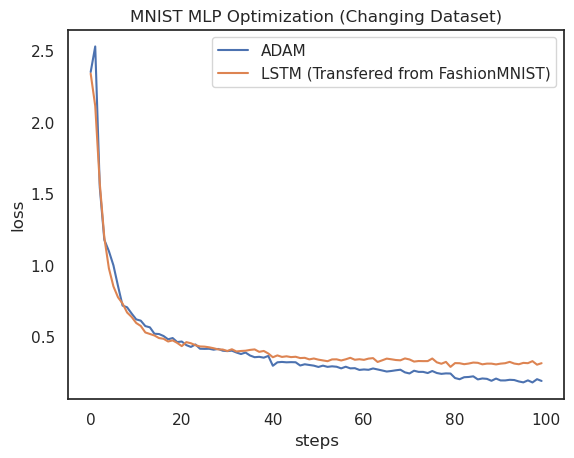

In [27]:
fit_data_mean = np.mean(fit_data, axis=0)
plt.plot(fit_data_mean[:, :], label=['ADAM', 'LSTM (Transfered from FashionMNIST)'])
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("MNIST MLP Optimization (Changing Dataset)")
plt.legend()
plt.show()

# BERT

In [8]:
# Creates batches of (x, y) where x is of (Seq, VocabSize) [ one of vocab_size is masked ] and y is of (1) [ vocab index of masked element ]
class MLMTarget:
    def __init__(self, training=True):
        dataset = load_dataset("openwebtext", split=("train")).with_format("torch", device=device)

        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=2,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))
    
        self.batches = []
        self.cur_batch = 0

        self.iter = iter(self.loader)

    def get_next_batch(self):
        # if self.cur_batch >= len(self.batches):
        #     self.batches = []
        #     self.cur_batch = 0
        #     for batch_idx, data in enumerate(self.loader):
        #         self.batches.append(data)
                
        # result = self.batches[self.cur_batch]
        # self.cur_batch += 1

        result = next(self.iter)

        # tokenize the data, ensuring it's on device
        result = self.tokenizer(result["text"], padding=True, truncation=True, return_tensors="pt").to(device)

        # get the random indices for each sequence to mask
        mask_indices = torch.randint(0, result["input_ids"].size()[1], result["input_ids"].size()[:1] + (1,)).to(device)

        # save the targets
        targets = result["input_ids"][torch.arange(result["input_ids"].size()[0]), mask_indices.squeeze()].to(device)

        # mask the data
        result["input_ids"][torch.arange(result["input_ids"].size()[0]), mask_indices.squeeze()] = self.tokenizer.mask_token_id

        # save the batch


        return (result, targets)

In [9]:
# Teensy BERT model with 1 transformer layers, and a hidden size of 32.
# Input and output are for masked language modeling.
# Expects input of shape (B, Seq, Vocab_Size), where one of the sequence elements is masked.
# Output is shape (B, Vocab_Size), where the masked element is predicted.
# Labels are expected of shape (B,) where each element is the vocab-size index of the masked element.
class BertTeensyNet(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.hidden_size = 32
        self.intermediate_size = 32
        self.vocab_size  = 30522
        self.num_attention_heads = 2
        self.num_layers = 1

        if (kwargs != {}):
            self.params = kwargs
        else:
            self.params = {}
            self.layer_norms = nn.ModuleList()
            # Embedding weights size: (vocab_size, hidden_size)
            self.params["W_e"] = nn.Parameter(torch.randn(self.vocab_size, self.hidden_size))
            self.params["b_e"] = nn.Parameter(torch.randn(self.hidden_size))

            # Define the Bert layers
            # Each layer contains: (1) self-attention, (2) dense layer (hidden -> intermediate), (3) dense layer (intermediate -> hidden)
            for i in range(self.num_layers):
                # Self attention weights size: (3*hidden_size, hidden_size)
                self.params["W_a" + str(i)] = nn.Parameter(torch.randn(3*self.hidden_size, self.hidden_size))
                # Self attention bias size: (hidden_size)
                self.params["b_a" + str(i)] = nn.Parameter(torch.randn(3*self.hidden_size))
                self.params["W_ao" + str(i)] = nn.Parameter(torch.randn(self.hidden_size, self.hidden_size))
                self.params["b_ao" + str(i)] = nn.Parameter(torch.randn(self.hidden_size))

                # dense intermediate
                # self.params["W_i" + str(i)] = nn.Parameter(torch.randn(self.hidden_size, self.intermediate_size))
                # self.params["b_i" + str(i)] = nn.Parameter(torch.randn(self.intermediate_size))

                # dense output
                # self.params["W_o" + str(i)] = nn.Parameter(torch.randn(self.intermediate_size, self.hidden_size))
                # self.params["b_o" + str(i)] = nn.Parameter(torch.randn(self.hidden_size))
                # self.layer_norms.append(nn.LayerNorm(self.hidden_size))

            # Define the weights for masked language prediction head
            # After 2nd attention layer (size: hidden_size), follow by a dense layer, then activation, then fc (from hidden_size to vocab_size)
            self.params["W_dense"] = nn.Parameter(torch.randn(self.hidden_size, self.hidden_size))
            self.params["b_dense"] = nn.Parameter(torch.randn(self.hidden_size))

            self.params["W_output"] = nn.Parameter(torch.randn(self.hidden_size, self.vocab_size))
            self.params["b_output"] = nn.Parameter(torch.randn(self.vocab_size))

            

            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
            
        self.layer_norm_pred = nn.LayerNorm(self.hidden_size)
        self.activation = nn.GELU()
        self.loss = nn.CrossEntropyLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]

    def forward(self, target: MLMTarget):
        x, y = target.get_next_batch()
        # Convert attention mask to bool mask
        attention_mask = x["attention_mask"].bool()
        x = x["input_ids"]
        y = y.long()

        # x is shape (B, Seq)
        # x is tensor of vocab indices, convert to one-hot
        x = F.one_hot(x, self.vocab_size)
        x = x.float()        
        
        # x is shape (B, Seq, Vocab_Size)
        # y is shape (B, Vocab_Size)


        # Embedding layer
        x = x @ self.params["W_e"] + self.params["b_e"]
        # x is shape (B, Seq, Hidden_Size)


        residual = x

        # Transformer Layers
        for i in range(self.num_layers):
            # Self attention
            # x should be seq first, batch second
            x = x.permute(1, 0, 2)
            x = F.multi_head_attention_forward(
                x, x, x, self.hidden_size, self.num_attention_heads, self.params["W_a" + str(i)], self.params["b_a" + str(i)], None, None, False, 0.0, self.params["W_ao" + str(i)], self.params["b_ao" + str(i)])[0]
            x = x.permute(1, 0, 2)

            # Dense intermediate
            # x = x @ self.params["W_i" + str(i)] + self.params["b_i" + str(i)]
            x = self.activation(x)

            # # Output (dense -> residual -> layernorm)
            # x = x @ self.params["W_o" + str(i)] + self.params["b_o" + str(i)]
            # x = x + residual
            # x = self.layer_norms[i](x)

            # residual = x

        
        # Masked language prediction head (dense -> activation -> layernorm -> fc decoder)
        # x is shape (B, Seq, Hidden_Size)
        x = x @ self.params["W_dense"] + self.params["b_dense"]
        x = self.activation(x)
        x = self.layer_norm_pred(x)
        x = x @ self.params["W_output"] + self.params["b_output"]

        # x is shape (B, Seq, Vocab_Size) [ vocab_size is logits ]

        loss = self.loss(x[:, 0, :], y)
        # print(loss)
        return loss
        

In [10]:
loss, bert_optimizer = fit_optimizer(MLMTarget, BertTeensyNet, lr=0.01, n_epochs=20, n_tests=20, preproc=True, out_mul=0.1)
print(loss)

epochs:   0%|          | 0/20 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


OutOfMemoryError: CUDA out of memory. Tried to allocate 300.00 MiB (GPU 0; 14.56 GiB total capacity; 13.45 GiB already allocated; 266.44 MiB free; 13.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
NORMAL_OPTS = [(torch.optim.Adam, {})]
OPT_NAMES = ['ADAM']
QUAD_LRS = [0.02]
fit_data = []
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)

    losses_adam = np.array(fit_normal(MLMTarget, BERTMLMNet, opt, n_tests=10, n_epochs=40, lr=lr, **extra_kwargs))
    fit_data.append(losses_adam)

opt_nets = {}
model_params = BERTMLMNet().all_named_parameters()
for (name, p) in model_params:
    opt_nets[name] = Optimizer_PP_LRM(p.size(), preproc=True).to(device)
    opt_nets[name].load_state_dict(mlm_optimizer[name])
losses_l2o = np.array([do_fit_lrm(opt_nets, None, MLMTarget, BERTMLMNet, 1, 40, 40, out_mul=0.1, should_train=False) for _ in range(10)])
unroll, optim_it, n_epochs, out_mul
fit_data.append(losses_l2o)

do_fit


Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


39.697823
do_fit


Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


19.284101
do_fit


Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


6.8747177
do_fit


Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


58.92972
do_fit


Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


27.819902
do_fit


Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


44.673676
do_fit


Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


26.281315
do_fit


Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


14.580837
do_fit


Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


43.16777
do_fit


Found cached dataset openwebtext (/home/dadur604604/.cache/huggingface/datasets/openwebtext/plain_text/1.0.0/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521)


20.715069
